---

### 00. Imported Libraries

---

In [ ]:
# data processing libraries
import pandas as pd
import numpy as np

# clustering, dimension-reduction algorithms
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

# soccer open-access database provided by StatsBomb
from statsbombpy import sb

# various plotting and image filtering libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
from mplsoccer import Pitch, VerticalPitch
from scipy.ndimage import gaussian_filter

# filter non-useful warnings
from warnings import filterwarnings
from statsbombpy.api_client import NoAuthWarning
filterwarnings('ignore', category=NoAuthWarning)
filterwarnings('ignore', category=FutureWarning)

# functions designed for this project - see linked
# project repository to learn more about these
# project-specific functions:
# https://github.com/lucas-nelson-uiuc/stat430_unsupervised_project
import proj_functions as pf


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler
from skfuzzy.cluster import cmeans

---

### 01. About the Dataset

---

Data for this project is provided by StatsBomb's OpenAccess platform. Within the dataset are a list of domestic, national, and international competitions for both male and female soccer clubs. These competitions range from regular season play within a country (e.g., Premier League (English), La Liga (Spanish)) to tournaments involving various countries (e.g., Champions League (European), Women's World Cup (international)), consisting of one or many matches depending on the format of the competition as well as - unfortunately - the amount of data provided by StatsBomb.

The table below breaks down the different ways a competition is categorized, including where the competition is held, which gender competes in it, the name of the competition, and which season the data is available for, as well as the number of matches available for said season.

In [ ]:
# gather all competitions provided in OpenAccess
pf.gather_sb_competitions()

---

### 02. Data Cleaning and Data Manipulation

---

##### i. Filtering Player-by-Player Stream Data

In [ ]:
invincibles_df = sb.matches(competition_id=2, season_id=44).sort_values('match_date').reset_index(drop=True)

In [ ]:
master_df = pd.concat([
    pf.preprocessing_events_df(sb.events(match_id=idx))
    for idx in invincibles_df['match_id']
]).reset_index(drop=True)

print(f'Number of events     -> {master_df.shape[0]}')
print(f'Number of attributes -> {master_df.shape[1]}')
master_df.head(3)

In [ ]:
# group master_df by player then by type
grouped_df = master_df.drop(columns='match_id').groupby(['player', 'type'])

# create dictionary of {player_name : {action_type: action_df}} for each player
player_dict = {player : dict() for player in master_df['player'].unique()}
for player_type, type_df in grouped_df:
    player_dict[player_type[0]][player_type[1]] = type_df

In [ ]:
for player in player_dict:
    for action in ['Pass', 'Shot', 'Dribble', 'Cross']:
        if action not in player_dict[player].keys():
            # assign empty vector for player for corresponding action
            player_dict[player][action] = pd.DataFrame([player, action, np.nan, np.nan, np.nan, 0, 0, 0, 0, 0, 0, 0]).T

            # ensure dimensions and columns match existing dataframes
            player_dict[player][action].columns=['player', 'type', 'shot_outcome', 'dribble_outcome', 
                'pass_cross', 'shot_statsbomb_xg', 'minute', 'second',
                'location_x', 'location_y', 'pass_end_x', 'pass_end_y']

##### ii. Minute Data per Player

Next, let's gather the total number of minutes each player spent on the pitch this season. Since the results of this analysis can be used to compare different players' playing vectors, we should probably ensure that it is a fair comparison by scaling each player's vector by the number of minutes played.

In [ ]:
time_df = pd.concat([
    pf.gather_time_information(sb.events(match_id=idx))
    for idx in invincibles_df['match_id']
]).reset_index(drop=True)

Let's calculate the difference between the maximum minute recorded and minimum minute recorded per player and store this in our `total_minutes_dict` dictionary for recollection later on.

In [ ]:
time_per_match = time_df.groupby(['player', 'match_id']).agg({'minute': ['min', 'max']})
total_minutes_df = pd.DataFrame(time_per_match['minute']['max'] - time_per_match['minute']['min']).reset_index().groupby(['player', 'match_id']).sum().rename(columns={0:'minutes'})
total_minutes_dict = total_minutes_df.to_dict()

---

### 05. Clusterability and Clustering Structure

---

Can we cluster our dataset?

In [ ]:
# tsne dataframe for shot type
master_tsne_shot = master_df[master_df['type'] == 'Shot'][['shot_outcome', 'shot_statsbomb_xg', 'location_x', 'location_y']]
master_tsne_shot[['location_x', 'location_y']] = master_tsne_shot[['location_x', 'location_y']].astype('float64')
master_tsne_shot['outcome'] = np.where(master_tsne_shot['shot_outcome'] == 'Goal', 'Goal', 'No goal')

# tsne dataframe for pass type
master_tsne_pass = master_df[master_df['type'] == 'Pass'][['pass_angle', 'pass_outcome', 'pass_shot_assist', 'pass_technique', 'location_x', 'location_y', 'pass_end_x', 'pass_end_y']]
master_tsne_pass[['location_x', 'location_y']] = master_tsne_pass[['location_x', 'location_y']].astype('float64')
master_tsne_pass[['pass_end_x', 'pass_end_y']] = master_tsne_pass[['pass_end_x', 'pass_end_y']].astype('float64')
master_tsne_pass['outcome'] = np.where(master_df[master_df['type'] == 'Pass']['pass_outcome'].isna(), 'Complete', 'Incomplete')

# tsne dataframe for dribble type
master_tsne_dribble = master_df[master_df['type'] == 'Dribble'][['dribble_outcome', 'location_x', 'location_y']]
master_tsne_dribble[['location_x', 'location_y']] = master_tsne_dribble[['location_x', 'location_y']].astype('float64')

# tsne dataframe for cross type
master_tsne_cross = master_df[master_df['type'] == 'Cross'][['location_x', 'location_y', 'pass_end_x', 'pass_end_y']]
master_tsne_cross[['location_x', 'location_y']] = master_tsne_cross[['location_x', 'location_y']].astype('float64')
master_tsne_cross[['pass_end_x', 'pass_end_y']] = master_tsne_cross[['pass_end_x', 'pass_end_y']].astype('float64')
master_tsne_cross['outcome'] = np.where(master_df[master_df['type'] == 'Cross']['pass_outcome'].isna(), 'Complete', 'Incomplete')

##### i. Selecting t-SNE Plots

Let's pick our favorite t-SNE plots and try to learn more about them.

##### **Shot**

In [ ]:
def plt_tsne_subplots(df, perps=[5,10,20,30,40,50], rss=[95, 433], drop_cols=[]):
    '''
    Create n_rows x n_cols grid of subplots for t-SNE plots of
    passed (subset) dataframe and perplexity/random
    state values
    '''

    n_rows, n_cols = len(rss), len(perps)
    f, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16,9))
    for i, rs in enumerate(rss):
        for j, perp in enumerate(perps):
            tsne = TSNE(n_components=2, perplexity=perp, random_state=rs)
            tsne_fit = tsne.fit_transform(df.drop(columns=drop_cols))
            tsne_data = pd.DataFrame(tsne_fit, columns=['x_proj', 'y_proj'])
            
            sns.scatterplot(x='x_proj', y='y_proj', data=tsne_data, ax=axs[i % n_rows, j % n_cols], legend=False)
            
            axs[i % n_rows, j % n_cols].set_title(f'perp={perp}, rs={rs}')
            axs[i % n_rows, j % n_cols].set_xticks([])
            axs[i % n_rows, j % n_cols].set_yticks([])
            axs[i % n_rows, j % n_cols].set_xlabel('')
            axs[i % n_rows, j % n_cols].set_ylabel('')

    return f

In [ ]:
tsne_shot_scaled = pd.DataFrame(
    StandardScaler().fit_transform(master_tsne_shot.drop(columns=['shot_outcome', 'outcome'])),
    columns=['shot_statsbomb_xg', 'location_x', 'location_y']
)

f = plt_tsne_subplots(tsne_shot_scaled, perps=[10,15,20,25,30,35], rss=[95,430,490])
plt.show()

In [ ]:
perp, rs = 15, 433

# pf.plt_tsne_subplots(
#     master_tsne_shot,
#     n_rows=1,
#     n_cols=1,
#     perps=[20],
#     rss=[433],
#     drop_cols=['shot_outcome', 'outcome']
#     )

tsne_shot_scaled = pd.DataFrame(
    StandardScaler().fit_transform(master_tsne_shot.drop(columns=['shot_outcome', 'outcome'])),
    columns=['shot_statsbomb_xg', 'location_x', 'location_y']
)

shot_tsne = TSNE(n_components=2, perplexity=perp, random_state=rs)
shot_tsne_fit = shot_tsne.fit_transform(tsne_shot_scaled)
shot_tsne_data = pd.DataFrame(shot_tsne_fit, columns=['x_proj', 'y_proj'])

f, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
shot_tsne_data['shot_statsbomb_xg'] = master_tsne_shot['shot_statsbomb_xg'].reset_index(drop=True)
shot_tsne_data['outcome'] = master_tsne_shot['outcome'].reset_index(drop=True)
sns.scatterplot(x='x_proj', y='y_proj', hue='outcome', data=shot_tsne_data, ax=axs[0])
sns.scatterplot(x='x_proj', y='y_proj', hue='shot_statsbomb_xg', data=shot_tsne_data, ax=axs[1])
sns.scatterplot(x='x_proj', y='y_proj', hue='shot_statsbomb_xg', style='outcome', data=shot_tsne_data, ax=axs[2])
axs[0].set_title('t-SNE with Binary Shot Outcome')
axs[1].set_title('t-SNE with Expected Goals')
axs[2].set_title('t-SNE with Both')
plt.show()

#### K-Means

In [ ]:
km = KMeans(n_clusters=2, random_state=100).fit(tsne_shot_scaled)
master_tsne_shot['cluster'] = km.labels_

In [ ]:
# tsne_shot_scaled
km.cluster_centers_

In [ ]:
for y_ax in ['shot_statsbomb_xg', 'location_x', 'location_y', 'binary_outcome']:
    print(f'Boxplot for {y_ax.upper()}')
    sns.boxplot(x='cluster', y=y_ax, data=master_tsne_shot)
    plt.show()

#### Fuzzy Clustering

In [ ]:
shot_transformed = pd.DataFrame(
    shot_tsne.fit_transform(tsne_shot_scaled),
    columns=['proj_x', 'proj_y']
    )

In [ ]:
X_array = np.array(shot_transformed).T
for p in np.linspace(1.01, 5, 10):
    cntr, W, _, _, _, _, pc = cmeans(X_array, c=2, m=p, error=1e-6, maxiter=20000, seed=1000)
    for i in range(0, 2):
        shot_transformed[f'c{i}_score'] = W[i, :]
        points = plt.scatter(
            shot_transformed['proj_x'],
            shot_transformed['proj_y'],
            c=shot_transformed[f'c{i}_score'],
            s=30,
            cmap='BuGn')
        plt.colorbar(points)

        plt.scatter(cntr[i][0], cntr[i][1], marker='x', color='orange')
        plt.title(f'Fuzzy Cluster {i}')
        plt.legend(bbox_to_anchor=(1,1))
        plt.show()


##### **Pass**

In [24]:
master_tsne_pass_sample.drop(columns=['outcome', 'pass_outcome', 'pass_technique'])

,pass_angle,pass_shot_assist,location_x,location_y,pass_end_x,pass_end_y
16848,0.407868,0,40.9,9.3,49.0,12.8
15638,1.689082,0,120.0,0.1,115.9,34.6
15793,2.220423,0,56.3,57.0,48.4,67.4
13024,-1.642787,0,65.9,62.0,64.4,41.2
8259,1.292497,0,18.6,26.7,25.4,50.5
...,...,...,...,...,...,...
8697,2.026248,0,39.2,32.6,29.6,52.2
14154,0.370891,0,34.9,30.4,45.7,34.6
3373,2.997935,0,40.7,51.6,24.8,53.9
4546,1.754374,0,55.4,46.0,49.7,76.7


In [30]:
np.random.seed(12345)
samples = np.random.choice(range(master_tsne_pass.shape[0]), size=800, replace=False)
master_tsne_pass_sample = master_tsne_pass.iloc[samples, :].copy()
# master_tsne_pass_sample['pass_shot_assist'] = np.where(master_tsne_pass_sample['pass_shot_assist'].isna(), 0, 1)
# tsne_pass_scaled = pd.DataFrame(
#     StandardScaler().fit_transform(master_tsne_pass_sample.drop(columns=['pass_angle', 'outcome', 'pass_outcome', 'pass_technique', 'pass_shot_assist'])),
#     columns=['location_x', 'location_y', 'pass_end_x', 'pass_end_y']
# )

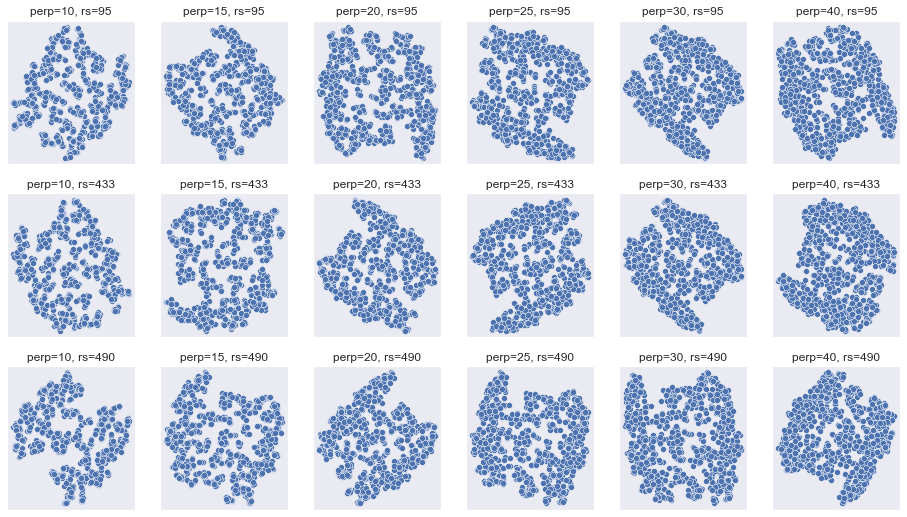

In [33]:
f = plt_tsne_subplots(
    master_tsne_pass_sample,
    perps=[10,15,20,25,30,40],
    rss=[95,433,490],
    drop_cols=['pass_angle', 'outcome', 'pass_outcome', 'pass_technique', 'pass_shot_assist']
)

plt.show()

In [ ]:
perp, rs = 30, 433

plt_tsne_subplots(
    master_tsne_pass_sample,
    perps=[perp],
    rss=[rs],
    drop_cols=['outcome', 'pass_outcome', 'pass_shot_assist', 'pass_technique']
    )

# pass_tsne = TSNE(n_components=2, perplexity=perp, random_state=rs)
# pass_tsne_fit = pass_tsne.fit_transform(master_tsne_pass_sample.drop(columns=['outcome', 'pass_outcome', 'pass_shot_assist', 'pass_technique']))
# pass_tsne_data = pd.DataFrame(pass_tsne_fit, columns=['x_proj', 'y_proj'])

# f, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
# pass_tsne_data['outcome'] = master_tsne_pass_sample['outcome'].reset_index(drop=True)
# pass_tsne_data['shot_assist'] = master_tsne_pass_sample['pass_shot_assist'].reset_index(drop=True).fillna(False)
# sns.scatterplot(x='x_proj', y='y_proj', hue='outcome', data=pass_tsne_data, ax=axs[0])
# sns.scatterplot(x='x_proj', y='y_proj', hue='shot_assist', data=pass_tsne_data, ax=axs[1])
# axs[0].set_title('t-SNE with Pass Outcome')
# axs[1].set_title('t-SNE with Expected Goals')
# plt.legend(bbox_to_anchor=(1,1))
# plt.show()

##### **Dribble**

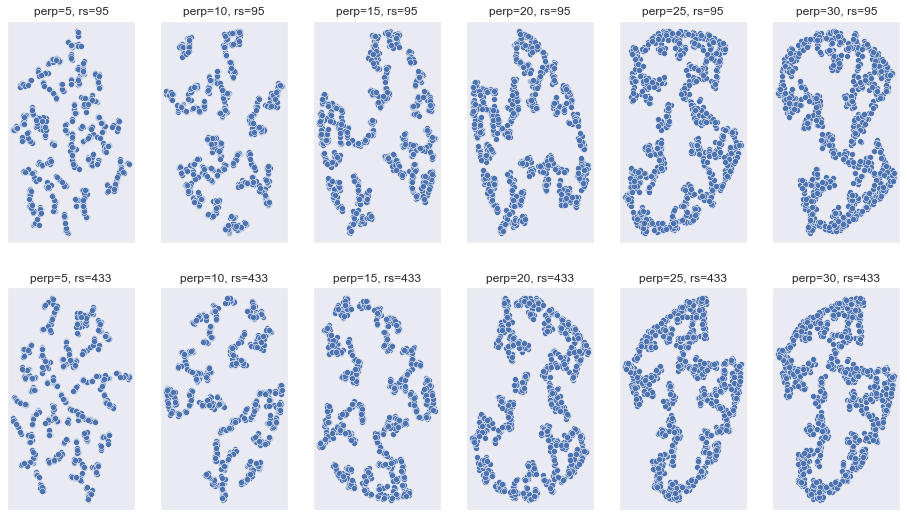

In [16]:
f = plt_tsne_subplots(
    master_tsne_dribble,
    perps=[5,10,15,20,25,30],
    drop_cols=['dribble_outcome']
)

plt.show()

In [ ]:
perp, rs = 20, 433

pf.plt_tsne_subplots(
    master_tsne_dribble,
    n_rows=1,
    n_cols=1,
    perps=[20],
    rss=[433],
    drop_cols=['dribble_outcome']
    )

# dribble_tsne = TSNE(n_components=2, perplexity=perp, random_state=rs)
# dribble_tsne_fit = dribble_tsne.fit_transform(master_tsne_dribble.drop(columns='dribble_outcome'))
# dribble_tsne_data = pd.DataFrame(dribble_tsne_fit, columns=['x_proj', 'y_proj'])

# dribble_tsne_data['outcome'] = master_tsne_dribble['dribble_outcome'].reset_index(drop=True)
# sns.scatterplot(x='x_proj', y='y_proj', hue='outcome', data=dribble_tsne_data)
# plt.legend(bbox_to_anchor=(1,1))
# plt.show()

##### **Cross**

In [ ]:
plt_tsne_subplots(
    master_tsne_cross,
    perps=[10,20,30,50,70,100],
    drop_cols=['outcome']
)

In [ ]:
perp, rs = 100, 433
cross_tsne = TSNE(n_components=2, perplexity=perp, random_state=rs)
cross_tsne_fit = cross_tsne.fit_transform(master_tsne_cross.drop(columns='outcome'))
cross_tsne_data = pd.DataFrame(cross_tsne_fit, columns=['x_proj', 'y_proj'])

cross_tsne_data['outcome'] = master_tsne_cross['outcome'].reset_index(drop=True)
sns.scatterplot(x='x_proj', y='y_proj', hue='outcome', data=cross_tsne_data)
plt.show()

In [34]:
def plt_actions_on_pitch(master_df, pitch):
    pass_df = master_df[master_df['type'] == 'Pass'].copy()
    pass_df[['location_x', 'location_y']] = pass_df[['location_x', 'location_y']].astype('float64')
    dribble_df = master_df[master_df['type'] == 'Dribble'].copy()
    dribble_df[['location_x', 'location_y']] = dribble_df[['location_x', 'location_y']].astype('float64')
    cross_df = master_df[master_df['type'] == 'Cross'].copy()
    cross_df[['location_x', 'location_y']] = cross_df[['location_x', 'location_y']].astype('float64')
    shot_df = master_df[master_df['type'] == 'Shot'].copy()
    shot_df[['location_x', 'location_y']] = shot_df[['location_x', 'location_y']].astype('float64')

    f, axs = pitch.grid(nrows=2, ncols=2,  # number of rows/ columns
                        figheight=8,  # the figure height in inches
                        bottom=0.025,  # starts 2.5% in from the figure bottom
                        # increased the grid_height as no title/ endnote
                        # now it takes up 95% of the figheight
                        grid_height=0.95,
                        grid_width=0.95,  # the grid takes up 95% of the figwidth
                        # 6% of the grid_height is the space between pitches.
                        space=0.06,
                        # set the endnote/title height to zero so
                        # they are not plotted. note this automatically
                        # sets the endnote/title space to zero
                        # so the grid starts at the bottom/left location
                        endnote_height=0, title_height=0)

    for color, action, action_df, ax in zip(
        ['#800020', '#9C824A', '#063672', '#DB0007'],
        ['Pass', 'Dribble', 'Cross', 'Shot'],
        [pass_df, dribble_df, cross_df, shot_df],
        axs['pitch'].flat):
        
        # if action == 'Shot': scale = action_df['shot_statsbomb_xg'] * 200
        # else: scale = None
        
        pitch.scatter(
            action_df['location_x'],
            action_df['location_y'],
            c=color,
            alpha=0.7,
            ec='black',
            ax=ax
            )
        
        sns.distplot(action_df['location_y'], ax=ax, color='#ba495c')
        sns.distplot(action_df['location_x'], ax=ax, color='#ba495c')
        
        ax.set_title(f'Distribution for {action}')

    return f